# Deep Learning with Lasagne: The Force Awakens 
![alt text](../images/boardgame.jpg)

### How the input looks?
![alt text](../images/dataset.png)

### Load your images into pandas

![alt text](../images/pandas_war.jpg)

In [1]:
import os
import pandas as pd
import cv2

star_wars_fn = './star_wars_data.csv'

In [2]:
def images_to_file(path_to_photos):
    """ """
    ids = [os.path.splitext(image_id)[0] for image_id in os.listdir(path_to_photos)]
    df_out = pd.DataFrame(columns=['Image', 'Model', 'Model_enc'], index=ids)
    for image_file in os.listdir(path_to_photos):
            image = cv2.imread(os.path.join(path_to_photos, image_file), 0)
            df_out['Image'][os.path.splitext(image_file)[0]] = ' '.join(map(str, image.flatten()))
            df_out['Model'][os.path.splitext(image_file)[0]] = image_file.split('_')[0]
       
    catenc = pd.factorize(df_out['Model'])
    df_out['Model_enc'] = catenc[0]
    print catenc
    df_out.to_csv(star_wars_fn)
    return df_out

### How my csv file look like?

In [3]:
!more ./star_wars_data.csv

,Image,Model,Model_enc
falcon_165,135 94 30 14 3 7 2 7 5 7 6 4 6 5 20 58 58 20 20 18 17 26 22 29 20 6 1
1 10 14 47 81 140 144 150 163 146 99 115 117 140 141 153 157 93 102 204 139 115 
140 150 63 14 20 35 38 32 63 49 53 42 65 67 75 107 159 117 37 68 113 43 102 57 3
0 37 52 20 12 22 23 34 24 28 29 66 94 56 38 46 53 39 23 53 58 21 63 119 152 81 7
6 148 161 253 228 172 212 242 228 223 227 213 168 177 164 138 105 125 147 144 14
4 132 140 130 124 130 127 137 174 196 79 41 36 18 11 5 5 4 6 5 5 7 9 5 15 48 60 
22 13 14 18 25 21 25 24 11 11 9 10 36 69 125 143 145 153 150 104 113 113 128 142
 145 165 160 109 161 166 133 126 161 79 10 39 36 43 40 43 47 37 47 56 69 114 136
 157 88 45 89 137 76 87 111 74 61 34 15 14 18 25 16 24 16 23 69 90 56 36 35 45 3
9 32 34 49 26 55 139 100 65 79 67 152 255 221 171 225 224 192 167 166 177 162 16
4 155 121 107 124 157 156 128 128 132 129 132 156 183 202 206 189 28 42 42 17 19
 31 1 16 8 5 5 8 11 5 10 36 60 28 9 11 16 18 20 23 25 16 10 11 9 24 58 110 137 1
36 14

### Let's build our net and prepare the data

In [3]:
import numpy as np
from sklearn.utils import shuffle
import os.path


In [4]:
def load(images_dir="../data/all/"):
    """Load images and target class for Falcon, Lambda and K-wing ships."""
    if os.path.exists(star_wars_fn):
        df = pd.read_csv(star_wars_fn)
    else:
        df = images_to_file(images_dir)
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    y = df['Model_enc'].values
    X, y = shuffle(X, y, random_state=42)
    y = y.astype(np.int32)
    
    return X, y

In [5]:
import theano
import lasagne
from lasagne.updates import nesterov_momentum, adam
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
                           MaxPool2DLayer, DenseLayer
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import BatchIterator


Using gpu device 0: GeForce GTX 860M (CNMeM is disabled, CuDNN not available)
/usr/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Let's define the layout

In [6]:
def create_net(max_epochs=100):
    return NeuralNet(
        layers=[
                (InputLayer, {'shape': (None, 1, 128, 128)}),
                (Conv2DLayer, {'num_filters': 16, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (Conv2DLayer, {'num_filters': 16, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DenseLayer, {'num_units': 100, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 3, 'nonlinearity': lasagne.nonlinearities.softmax}),
        ],
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,
        regression=False,
        objective_loss_function=categorical_crossentropy,
        #batch_iterator_train=BatchIterator(batch_size=512),
        #on_epoch_finished=[
        #    AdjustVariable('update_learning_rate', start=0.03, stop=0.001),
        #    AdjustVariable('update_momentum', start=0.9, stop=0.9999)  # ,
        #],
        max_epochs=max_epochs,
        verbose=1)

In [7]:
from sklearn.cross_validation import train_test_split
x, y = load()
x = x.reshape(-1, 1, 128, 128)
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=42)
print X_train.shape 

(2924, 1, 128, 128)


In [8]:
net = create_net(20)
net.fit(X_train, y_train)

# Neural Network with 1442883 learnable parameters

## Layer information

  #  name        size
---  ----------  ----------
  0  input0      1x128x128
  1  conv2d1     16x126x126
  2  maxpool2d2  16x63x63
  3  conv2d3     16x61x61
  4  maxpool2d4  16x30x30
  5  dense5      100
  6  dropout6    100
  7  dense7      3

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.08339     1.02741    1.05449      0.64444  3.23s
      2     0.97933     0.94060    1.04118      0.55043  3.27s
      3     0.90109     0.80580    1.11826      0.71795  3.23s
      4     0.78475     0.65665    1.19508      0.74359  3.22s
      5     0.67722     0.58354    1.16055      0.78803  3.23s
      6     0.58443     0.45789    1.27636      0.85128  3.22s
      7     0.47658     0.34219    1.39273      0.86838  3.22s
      8     0.40522     0.34929    1.16013      0.90256  3.22s
      9     0.34573     0.23762    1.45501      0.912

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f11730eef50>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f11730eee50>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 128, 128)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'W': <lasagne.init.GlorotUniform object at 0x7f11730fa490>, 'num_filters': 16}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': 2}), (<cla....layers.dense.DenseLayer'>, {'num_units': 3, 'nonlinearity': <function softmax at 0x7f1178807ed8>})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7f11730f21b8>,
     objective_loss_function=<function categorical_crossentropy at 0x7f11785d31b8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f1173105098>],
     on_training_finished=[],
     on_

### Let's check the metrics on this net

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nolearn.lasagne import visualize

In [10]:
print classification_report(y_test, net.predict(X_test))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       330
          1       0.95      0.99      0.97       473
          2       0.98      0.96      0.97       451

avg / total       0.97      0.97      0.97      1254



In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

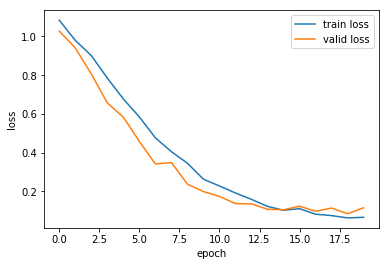

In [12]:
%matplotlib inline
visualize.plot_loss(net)


![alt text](../images/confusion_matrix.png)

In [13]:
def plot_matrix(clf, X_test, y_test):
    """Plot Confussion Matrix from a given classifier"""
   
    plt.clf()
    
    cm = confusion_matrix(y_test, clf.predict(X_test))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    print(cm_normalized)
    plt.tick_params(labelsize=20)

    ax = plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Reds)
    cb = plt.colorbar()
    cb.ax.tick_params(axis='both', labelsize=20)
    plt.ylabel("True label", fontsize=20)
    plt.xlabel("Predicted label", fontsize=20)
    plt.xticks(range(3),range(3))
    plt.yticks(range(3),range(3))



Normalized confusion matrix
[[ 0.96969697  0.01515152  0.01515152]
 [ 0.00422833  0.99154334  0.00422833]
 [ 0.00221729  0.0421286   0.9556541 ]]
[[320   5   5]
 [  2 469   2]
 [  1  19 431]]


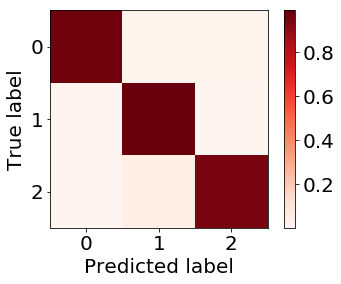

In [14]:
plot_matrix(net, X_test, y_test)
print confusion_matrix(y_test, net.predict(X_test))

### You can save your network in a pickle!

In [15]:
import cPickle as pickle

with open('../data/ship_classifier.pickle', 'wb') as f:
        pickle.dump(net, f, -1)


In [16]:
net_loaded = None
with open('../data/ship_classifier.pickle', 'rb') as f:
       net_loaded = pickle.load(f)

In [17]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()

net_loaded.verbose = 1
net_loaded.initialize()
layer_info(net_loaded)

# Neural Network with 1442883 learnable parameters

## Layer information

  #  name        size
---  ----------  ----------
  0  input0      1x128x128
  1  conv2d1     16x126x126
  2  maxpool2d2  16x63x63
  3  conv2d3     16x61x61
  4  maxpool2d4  16x30x30
  5  dense5      100
  6  dropout6    100
  7  dense7      3



### What's happening inside?

In [18]:
net.layers

[(lasagne.layers.input.InputLayer, {'shape': (None, 1, 128, 128)}),
 (lasagne.layers.conv.Conv2DLayer,
  {'W': <lasagne.init.GlorotUniform at 0x7f11730fa490>,
   'filter_size': 3,
   'num_filters': 16}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'W': <lasagne.init.GlorotUniform at 0x7f11730fa4d0>,
   'filter_size': 3,
   'num_filters': 16}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.dense.DenseLayer,
  {'nonlinearity': <function lasagne.nonlinearities.rectify>,
   'num_units': 100}),
 (lasagne.layers.noise.DropoutLayer, {'p': 0.5}),
 (lasagne.layers.dense.DenseLayer,
  {'nonlinearity': <function lasagne.nonlinearities.softmax>, 'num_units': 3})]

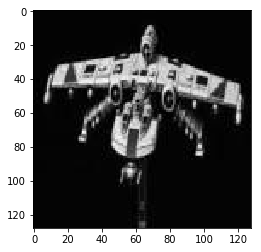

In [19]:
%matplotlib inline

my_image = cv2.imread("../data/kwing.jpg", 0)
plt.imshow(my_image, cmap='gray')
X = np.vstack(my_image) / 255.
plt.imshow(X, cmap='gray')
X = X.astype(np.float32)
X = X.reshape(-1, 1, 128, 128)

In [20]:
net.predict(X)

array([2])

In [21]:
proba = net.predict_proba(X)
proba, proba.sum()

(array([[  1.77244227e-02,   3.91801674e-04,   9.81883883e-01]], dtype=float32),
 1.0000001)

In [22]:
proba[0, np.argmax(proba)]

0.98188388

#### Qué pasa si tapamos partes de nuestra imagen?? Que partes son importantes para la clasificación??

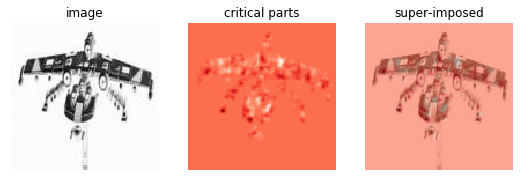

In [38]:
h = visualize.plot_occlusion(net, X, [2], square_length=3)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

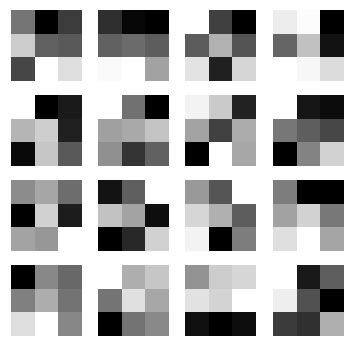

In [28]:
visualize.plot_conv_weights(net.layers_[1])

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

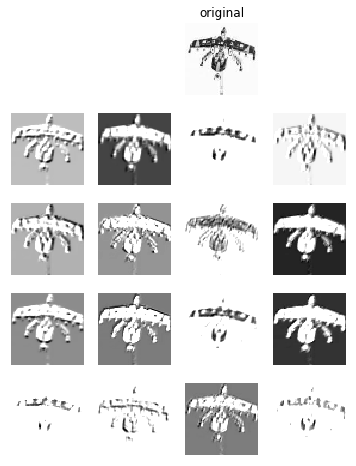

In [39]:
visualize.plot_conv_activity(net.layers_['conv2d3'], X)

### Now we will use are net over video!!

In [25]:
tipos_naves = {0: 'Falcon', 1: 'Lambda', 2: 'K-wing'}

def format_net(my_image):
        X = np.vstack(my_image) / 255.
        X = X.astype(np.float32)
        X = X.reshape(-1, 1, 128, 128)
        
        return X

In [26]:
import time
import cv2

def classifier_over_video(file_name):
    cap = cv2.VideoCapture(file_name)
    frames_count = cap.get(7)
    
    for frame_id in range(int(frames_count)):
        ret, frame = cap.read()
        frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_ = cv2.equalizeHist(frame_)
        res = cv2.resize(frame_, (128, 128), interpolation = cv2.INTER_CUBIC)
        X = format_net(res)
        
        pred = tipos_naves[net.predict(X)[0]]
        proba = net.predict_proba(X)
        proba = str(proba[0, np.argmax(proba)])
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, pred, (10, 500), font, 4, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(frame, proba, (10, 800), font, 4, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.imshow('frame',frame)
        cv2.waitKey(1)
        
    cap.release()
    cv2.destroyAllWindows()

In [27]:
classifier_over_video("../data/videos_demo/otro_k-wing_nerdearla.mp4")

#### And if you want a more stable video classification ...

In [33]:
import time
import cv2
from collections import Counter

def classifier_over_video_most_common(file_name):
    cap = cv2.VideoCapture(file_name)
    frames_count = cap.get(7)
    clase = []
    
    for frame_id in range(int(frames_count)):
        ret, frame = cap.read()
        frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_ = cv2.equalizeHist(frame_)
        res = cv2.resize(frame_, (128, 128), interpolation = cv2.INTER_CUBIC)
        X = format_net(res)
        clase.append(net.predict(X)[0])
        font = cv2.FONT_HERSHEY_SIMPLEX
        mi_nave_frecuente = Counter(clase).most_common(1)[0][0]
        cv2.putText(frame, tipos_naves[mi_nave_frecuente], (10,500), font, 4,(255,255,255), 2, cv2.LINE_AA)
        cv2.imshow('frame', frame)
        cv2.waitKey(1)
        
    cap.release()
    cv2.destroyAllWindows()

In [34]:
classifier_over_video_most_common("../data/videos_demo/otro_k-wing_nerdearla.mp4")